# Simulations of multi-scale fairy circles

Import packages

In [1]:
import numpy as np
import cupy as cp
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from src.utils import get_homogeneous_system, save, load
from src.solver import solver
from matplotlib.colors import LinearSegmentedColormap
fc_cmap=LinearSegmentedColormap.from_list('mycolormap', [(0,'#D69268'), (0.15, '#456941'), (1.0,'#004b23')], N=128)

Define model parameters as a dictionary

In [2]:
# Initialize an empty parameter dictionary
params = {}

# Assign values to parameters
params['p'] = 149  # Precipitation (varied between 30-250)
params['Z1'] = 200; params['Z2'] = 300  # Vertical length of i-th soil layer
params['n1'] = 0.5; params['n2'] = 0.3  # Porosity of i-th soil layer
params['e1'] = 8.0; params['e2'] = 5.0  # Root augmentation per unit biomass of phenotype i
params['k1'] = 0.4; params['k2'] = 0.7  # Maximum standing biomass of phenotype i
params['m1'] = 10.0; params['m2'] = 2.0  # Mortality rate of phenotype i 
params['N'] = 15.0  # Maximum evaporation rate of upper soil moisture
params['lam1'] = 0.38; params['lam2'] = 0.24  # Growth rate per unit soil-water in the i-th layer
params['gam1'] = 12; params['gam2'] = 12  # Soil water consumption rate in the i-th layer per unit biomass
params['r1'] = 0.2; params['r2'] = 0.2  # Evaporation reduction due to shading (ρ)
params['l1'] = 1.0; params['l2'] = 1.0  # Mean dispersal distance of the i-th phenotype
params['Rmin'] = 0.25; params['Rmax'] = 0.5  # Maximum(minimum) germination probabilities
params['fe1'] = 0.25; params['fe2'] = 0.25  # Fecundity (f)
params['gs'] = 40  # Specific conversion rate of seeds into seedlings
params['db1'] = params['gs'] * params['fe1']; params['db2'] = params['gs'] * params['fe2']
params['dr'] = 0.001  # Re-sprouting rate from rhizome buds of dormant phenotype 2 individuals
params['ds1'] = 1000; params['ds2'] = 1/5  # Diffusion rate of soil moisture in i-th soil layer
params['br'] = 0.3  # Biomass of mean germination probability
params['theta1'] = 1/4; params['theta2'] = 1.0 - params['theta1']  # Fraction of water consumed from the upper layer by phenotype 2 (θ)
params['beta1'] = 6000; params['beta2'] = 2000  # Percolation rate from the ith soil layer to the next deeper soil layer
params['a'] = 7.0  # Maximum rate of phenotypic transition
params['s1star'] = 0.03; params['s2star'] = 0.0023  # Half-saturation constant of soil water in the i-th layer


Define numerical simulation parameters

In [3]:
xmax=40  # domain length
ymax=xmax

dt=0.005  # time step
NN=128*16  # number of spatial grid point

tmax=150  # Time

steps=int(tmax/dt) 
t_steps=steps/tmax  # number of steps per time unit

Lx=xmax/2
Ly=Lx

# set up Fourier domain
kx=(np.pi/Lx)*np.concatenate((np.arange(0,NN/2 +1),np.arange(-NN/2 +1,0))).astype('float32')
ky=(np.pi/Ly)*np.concatenate((np.arange(0,NN/2 +1),np.arange(-NN/2 +1,0))).astype('float32')
[kxx, kyy]=np.meshgrid(np.asarray(kx), np.asarray(ky))
ksq=(kxx**2 + kyy**2)

Calculate the homogeneous steady state to initialise simulations

In [4]:
tstop = 2000
y_guess = [0.3, 0.05, 0.3, 0.05]
y0 = odeint(get_homogeneous_system(params), y0=y_guess, t=np.arange(0, 2000, 0.001))[-1, :]  # take last time point

Define random initial conditions

In [5]:
amp=0.05
u1 = np.ones([NN,NN])*y0[0] + np.random.uniform(-amp/2,amp/2,(NN,NN))*y0[0]
v1 = np.ones([NN,NN])*y0[1] + np.random.uniform(-amp/2,amp/2,(NN,NN))*y0[1]
u2 = np.ones([NN,NN])*y0[2] + np.random.uniform(-amp/2,amp/2,(NN,NN))*y0[2]
v2 = np.ones([NN,NN])*y0[3] + np.random.uniform(-amp/2,amp/2,(NN,NN))*y0[3]

Load quantities onto GPU using CuPy

In [6]:
ksq=cp.asarray(ksq).astype('float32')
u1=cp.asarray(u1).astype('float32')
v1=cp.asarray(v1).astype('float32')
u2=cp.asarray(u2).astype('float32')
v2=cp.asarray(v2).astype('float32')

Initialise storage arrays 

In [20]:
t=0
save_interval = 1  # time interval (in years) after which we save the solution
save(f'../data/simulations/run1/0.pickle', u1, v1, u2, v2, params)  # save initial condition
for n in tqdm(range(0, steps)):
    u1, v1, u2, v2 = solver(u1, v1, u2, v2, params, ksq, dt)
    t = t + dt
    if (n % int(np.round(save_interval/dt))) == 0:
        save(f'../data/simulations/run1/{int(t)}.pickle', u1, v1, u2, v2, params)

100%|██████████| 30000/30000 [1:04:09<00:00,  7.79it/s]


Load data from year 120:

In [17]:
data = load('../data/simulations/run1/120.pickle')

Plot and save:

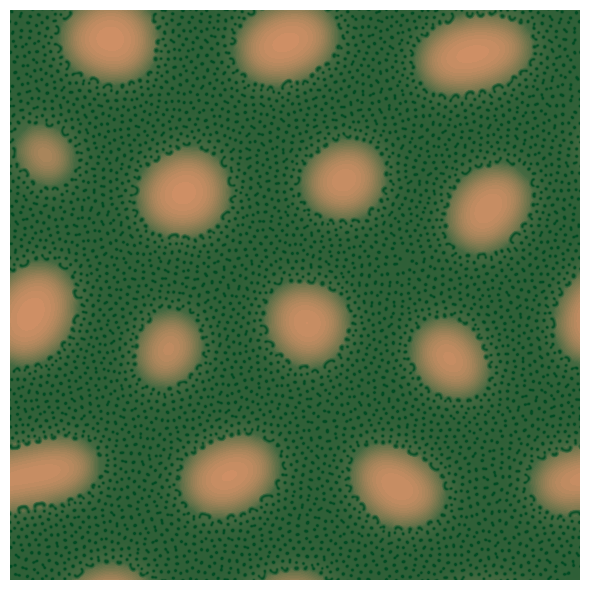

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(data['u1']+data['u2'], extent=[0, 40, 0, 40], cmap=fc_cmap, vmin=0.0, vmax=0.6)
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../images/fc_120.png')

Now let's reduce the mean annual precipitation:

In [9]:
# set previous solution as initial condition and change p
t=120
u1 = cp.asarray(data['u1']).astype('float32')
v1 = cp.asarray(data['v1']).astype('float32')
u2 = cp.asarray(data['u2']).astype('float32')
v2 = cp.asarray(data['v2']).astype('float32')
params['p'] = 60
steps = int(10/dt) # simulation for 10 years

save_interval = 1  # time interval (in years) after which we save the solution
for n in tqdm(range(0, steps)):
    u1, v1, u2, v2 = solver(u1, v1, u2, v2, params, ksq, dt)
    t = t + dt
    if (n % int(np.round(save_interval/dt))) == 0:
        save(f'../data/simulations/run2/{int(t)}.pickle', u1, v1, u2, v2, params)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [04:06<00:00,  8.11it/s]


Load data from year 125:

In [19]:
data = load('../data/simulations/run2/129.pickle')

Plot and save image:

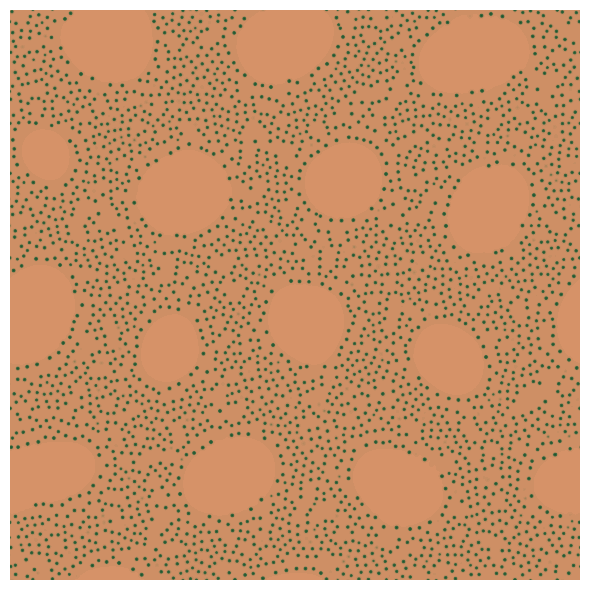

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(data['u1']+data['u2'], extent=[0, 40, 0, 40], cmap=fc_cmap, vmin=0.0, vmax=0.6)
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../images/fc_129.png')